# Part 3: Building a left/right federal electorate classifier

## Executive Summary:
* With the exploratory data analysis and the modeling out of the way, I can now focus on achieving what I set out to do with this project. I believe that a major part of this project was collecting, cleaning and organising data from a variety of sources, bringing them together into a finished product that can offer some good insights. 


* The work I had done before, in cleaning and manually constructing the data has made it very easy to just get straight into the modeling. There are no missing values, and all the data is on the same scale as a proportion, and all the data is in the correct data type. 

**Goals:**

* My goal for the modeling aspect was to create a model that could accurately predict whether an Australian Federal Electorate was left or right leaning for the 2019 federal election. From this, I wanted to learn what coefficients offered the best predictability into whether a seat will vote left or right.

**Metrics:**

* The key to success for this model is accuracy and relative balance in predicting left and right leaning seats. For business uses, it needs to perform far above the baseline, and the variance in cross validating needs to be as small as possible. While errors will be inevitable, I am focusing on minimising the spread of errors across false left / false right leaning seats. 


* Another metric to success is getting good quality insights into the data via the coefficients. I believe this will require a degree of feature engineering or merging, as there are lots of random coefficients in the final data frame.


## Results and findings:

* Below I will go through the process of my modeling, going through 5 different models, before choosing the best one out of the lot and writing a conclusion based off of the best performing model.

In [1]:
#Importing the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Importing my own set of functions from a script for cleanliness and readability of this notebook
from modality import modeler as md

In [3]:
#Reading in the cleaned version of my finished data frame
ced_df = pd.read_csv('./Database/CED_model.csv')

In [4]:
#Checking the shape
ced_df.shape

(876, 290)

In [5]:
#Adjusting the data frame display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows',20)

In [6]:
#defining the feature that will be excluded for the predictor matrix
feats_to_excl = ['divisionnm','divisionid','stateab','partyab','lncvotes','lncpercentage','alpvotes','alppercentage',
                 'swing','election_year','candidateid','givennm','surname','partynm','enrolment','turnout',
                 'turnoutpercentage','turnoutswing','totalpercentage','closeofrollsenrolment','notebookrolladditions',
                 'notebookrolldeletions','reinstatementspostal','reinstatementsprepoll','reinstatementsabsent',
                 'reinstatementsprovisional','year','ced','ced_state','census_year']

#testing if they're all in the columns
all([feat in ced_df.columns for feat in feats_to_excl])

True

### Model 1: Simple Logistic Regression

* The first model I will build is a simple logistic regression model, with minimal feature engineering and no hyperparameter tuning. This will be a good starting point for evaluation of my other models going forward.

In [7]:
#Importing the necessary packages for modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [8]:
#Defining the data as everything not including the specified 'features to drop' above, as they will not work
data = ced_df.drop(columns=feats_to_excl)

In [9]:
#Defining the X and Y's
X = data[[col for col in data.columns if 'is_right' not in col]]
y = data['is_right']

In [10]:
#Defining the baseline as the proportion of the occurrence of the largest class in the data set
baseline = y.value_counts(normalize=True)[1]
print(baseline)

0.5468036529680366


In [11]:
#Defining the simple logistic regression model
lr = LogisticRegression()

#Scoring based on best estimator from above
scores_acc = cross_val_score(lr,X,y,cv=10,scoring='accuracy')
scores_prec = cross_val_score(lr,X,y,cv=10,scoring='precision')
scores_rec = cross_val_score(lr,X,y,cv=10,scoring='recall')
scores_f1 = cross_val_score(lr,X,y,cv=10,scoring='f1')

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv acc mean:',np.mean(scores_acc),'std:',np.std(scores_acc))
print('Model cv prec mean:',np.mean(scores_prec),'std:',np.std(scores_prec))
print('Model cv rec mean:',np.mean(scores_rec),'std:',np.std(scores_rec))
print('Model cv f1 mean:',np.mean(scores_f1),'std:',np.std(scores_f1))

Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv acc mean: 0.8903571602148187 std: 0.02526070224634009
Model cv prec mean: 0.8961143433846328 std: 0.028503667505806757
Model cv rec mean: 0.9061170212765959 std: 0.049437889561545635
Model cv f1 mean: 0.89995501696697 std: 0.024526371594976268


* The scoring methodologies I have chosen are accuracy, precision, recall and f1 score. They are the gold standard for evaluating classification models and give a good overview of how my model has performed compared to the baseline. 


* This is just a first score, but as we can see is performing far above the baseline for predicting left/right. However, for actual usability it makes the most sense to test and train the data on previous years, to predict the most recent election. Going forward, this will be the standard for evaluating how my model is performing.


* To do this, I have written a function that trains and tests data based on election years and different states as 'folds'. Training and testing the model based on these folds makes the most sense of practical use. 

In [12]:
#Defining two lists of eleciton years and of different states, they will be trained and tested across all folds
election_years = [2004,2007,2010,2013,2016,2019]
states = ['NSW','VIC','QLD','WA','SA','TAS','NT','ACT']

In [13]:
#The custom scorer function outputs a table of all evaluation measures for every state fold (more info refer docstring)
state_folds = md.custom_scorer('stateab',states,d_f=ced_df,dp=feats_to_excl)

#Taking the means of the various scores from the state folds table
acc_mean = state_folds['accuracy'].mean()
acc_std = state_folds['accuracy'].std()

rec_mean = state_folds['recall'].mean()
rec_std = state_folds['recall'].std()

prec_mean = state_folds['precision'].mean()
prec_std = state_folds['precision'].std()

f1_mean = state_folds['f1'].mean()
f1_std = state_folds['f1'].std()

#Printing the mean scores of the scores based on state folds
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on states acc mean:',acc_mean,'std:',acc_std)
print('Model cv on states prec mean:',rec_mean,'std:',rec_std)
print('Model cv on states rec mean:',prec_mean,'std:',prec_std)
print('Model cv on states f1 mean:',f1_mean,'std:',f1_std)


Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on states acc mean: 0.7102011706985941 std: 0.18772181919589184
Model cv on states prec mean: 0.46346747220785384 std: 0.3938451879389033
Model cv on states rec mean: 0.6308487683487684 std: 0.40980401705601677
Model cv on states f1 mean: 0.6405059273392898 std: 0.22914046882678757


In [14]:
#Outputting the state fold scores
state_folds

,accuracy,recall,precision,f1
NSW,0.751773,0.823129,0.733333,0.775641
VIC,0.738532,0.969072,0.635135,0.767347
QLD,0.482955,0.314961,0.909091,0.467836
WA,0.670455,0.781250,0.769231,0.775194
SA,0.828125,0.676471,1.000000,0.807018
TAS,0.793103,0.142857,1.000000,0.250000
NT,0.416667,0.000000,0.000000,NaN
ACT,1.000000,0.000000,0.000000,NaN


* We can see already that there is quite a bit of diversity in the scores fitted across different states. Obviously the difference in number of electorates between states / territories, but Queensland, with similar number of electorates bucks the trend of the other bigger states and has a much lower accuracy than the other states. This reflects Queensland generally being a bit of a 'wildcard' of previous elections.

In [15]:
#The custom scorer cross validates based on election year folds, similar to state folds above (refer to docstring)
election_folds = md.custom_scorer('year',election_years,d_f=ced_df,dp=feats_to_excl)

acc_mean = election_folds['accuracy'].mean()
acc_std = election_folds['accuracy'].std()

rec_mean = election_folds['recall'].mean()
rec_std = election_folds['recall'].std()

prec_mean = election_folds['precision'].mean()
prec_std = election_folds['precision'].std()

f1_mean = election_folds['f1'].mean()
f1_std = election_folds['f1'].std()

#Printing the mean scores of the scores based on election year folds
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on elections acc mean:',acc_mean,'std:',acc_std)
print('Model cv on elections prec mean:',rec_mean,'std:',rec_std)
print('Model cv on elections rec mean:',prec_mean,'std:',prec_std)
print('Model cv on elections f1 mean:',f1_mean,'std:',f1_std)


Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on elections acc mean: 0.8358093823328147 std: 0.09175517917817386
Model cv on elections prec mean: 0.821032171226128 std: 0.1932947488903248
Model cv on elections rec mean: 0.8906606897876856 std: 0.08389361158249492
Model cv on elections f1 mean: 0.8377634000132117 std: 0.10200229493395266


In [16]:
election_folds

,accuracy,recall,precision,f1
2004,0.682759,0.522727,0.920000,0.666667
2007,0.828767,0.984848,0.730337,0.838710
2010,0.917808,0.932432,0.907895,0.920000
2013,0.871622,0.827957,0.962500,0.890173
2016,0.926667,1.000000,0.877778,0.934911
2019,0.787234,0.658228,0.945455,0.776119


* We can see that making predictions on years over states is far more accurate and has higher scores across the board. This is mainly because the election year folds encompass voting habits of all states, and that the pattern of voting is much more consistent across years than across states.


* With the election folds table, we are not really concerned with the scores of the previous year, as it is not practical to fit a model around subsequent elections to predict an election that has already occurred. We are only concerned with the 2019 score, which is at about a 78% accuracy, above the baseline and a gives a good indication of how this model will perform. 

#### Simple Logistic Regression: Predicting 2019

* Now that we have an idea of how the model is performing for predicting the 2019 election, we will go in much deeper to assess its performance and see what coefficients determine whether a seat is left or right leaning.

In [17]:
#Defining the training X and Y's, all rows which are not election year 2019
X_train = ced_df[ced_df['year'] != 2019][[col for col in ced_df.columns if 'is_right' not in col]]
X_train = X_train.drop(columns=feats_to_excl)
y_train = ced_df[ced_df['year'] != 2019]['is_right']

#Defining the testing X and Y's, all rows which are election year 2019
X_test = ced_df[ced_df['year'] == 2019][[col for col in ced_df.columns if 'is_right' not in col]]
X_test = X_test.drop(columns=feats_to_excl)
y_test = ced_df[ced_df['year'] == 2019]['is_right']

In [18]:
#Making a new logistic regression object
lr = LogisticRegression()

#Fitting the model to the training data
lr_mod = lr.fit(X_train,y_train)

In [19]:
#Getting a list of predictions
y_pred = lr_mod.predict(X_test)

In [20]:
#Outputting a confusion matrix for the predictions and actual scores
md.confusion_matrix(y_test,y_pred)

,Predicted positive,Predicted negative
Actual Positive,52,27
Actual Negative,3,59


* The confusion matrix reveals something interesting, the model does a much better job of predicting left leaning seats than right leaning seats, with far more false negatives (false left) than false positives (false right). This suggests, that the right leaning seats have voted right despite their demographic characteristics suggesting otherwise. I believe that this aligns with the relative surprise of the 2019 election, which went against predictions of voting right when they were predicted to vote left.

In [21]:
#Assigning a variable to the probability table function which outputs the probability of the seat voting right/left
#while demonstrating the predicted and actual results (refer to docstring for more information)
probs_1 = md.probability_table(lr_mod,X_test,y_test,ref_df=ced_df)
probs_1

,is_left_pct,is_right_pct,electorate,predicted,actual
0,99.9525,0.0475,Adelaide,left,left
1,36.3460,63.6540,Aston,right,right
2,99.9892,0.0108,Ballarat,left,left
3,31.0102,68.9898,Banks,right,right
4,0.0004,99.9996,Barker,right,right
5,96.9995,3.0005,Barton,left,left
6,99.1995,0.8005,Bass,left,right
7,99.9524,0.0476,Bendigo,left,left
8,58.5003,41.4997,Bennelong,left,right
9,0.0002,99.9998,Berowra,right,right


In [22]:
#Printing the mean probability of left/right as a gauge for how confident the model was in predicting each class
print('Mean left leaning probability is {0:.2f}%'.format(probs_1['is_left_pct'].mean()))
print('Mean right leaning probability is {0:.2f}%'.format(probs_1['is_right_pct'].mean()))

Mean left leaning probability is 60.20%
Mean right leaning probability is 39.80%


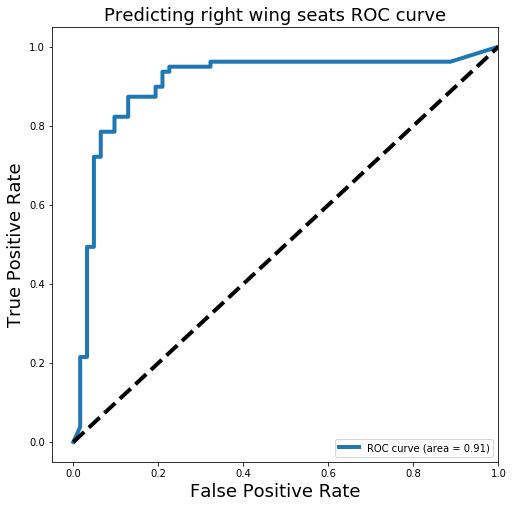

In [23]:
#Outputting the results into a roc curve graph for more evaluation
md.roc_curve_grapher(y_test,probs_1['is_right_pct'],title='Predicting right wing seats ROC curve')

* At this point we can see the model is performing quite well, but not perfectly. Various tests have shown us, that the model does a much better job at predicting left leaning seats than right leaning seats. For practicality purposes, this is quite far off the mark and I will need to do some tuning to improve. 

In [24]:
#Getting coefficient values into a dataframe and zipping them with the coefficient names for graphing
c_coefs = pd.DataFrame(dict(zip(X_train.columns,lr_mod.coef_[0])),index=['Value']).T
c_coefs['ABS_Value'] = c_coefs['Value'].apply(abs)
#Applying the logit convert function (refer to docstring) to convert the coefficients into probabilities
c_coefs['Probability'] = c_coefs['Value'].apply(md.logit_convert)
#Outputting the data frame sorting by Value
c_coefs.sort_values(by='Value',ascending=False)

,Value,ABS_Value,Probability
rental_hiring_and_real_estate_services_pct,1.354953,1.354953,0.794938
both_not_stated___both_institution_typp_and_full_time_part_time,1.073693,1.073693,0.745299
western_europe_pct,0.982213,0.982213,0.727547
north_africa_pct,0.924110,0.924110,0.715879
employer_government_includes_defence_housing_authority_pct,0.907857,0.907857,0.712561
being_occupied_under_a_life_tenure_scheme_pct,0.902118,0.902118,0.711385
hrswrkd_49_hours_and_over_pct,0.873681,0.873681,0.705511
_15_19_years_pct,0.868108,0.868108,0.704352
income_1000_1249_pct,0.858002,0.858002,0.702243
married_pct,0.855693,0.855693,0.701760


Enter your electorate name: Bennelong
The seat of Bennelong was predicted to have a 58.5003 % probability of being left leaning
The 2019 election saw Bennelong as voting right leaning

How your seat scored on top 10 left leaning predictors:
------
being_occupied_rent_free_pct feature was in the 59.87th percentile.
never_married_pct feature was in the 73.68th percentile.
polynesia_excludes_hawaii_pct feature was in the 76.97th percentile.
new_zealand_pct feature was in the 41.45th percentile.
_45_49_years_pct feature was in the 40.13th percentile.
hrswrkd_40_hours_pct feature was in the 96.71th percentile.
graduate_diploma_and_graduate_certificate_level_pct feature was in the 73.68th percentile.
postgraduate_degree_level_pct feature was in the 94.08th percentile.
familyincome_1500_1999__pct feature was in the 30.26th percentile.
level_of_education_not_stated_pct feature was in the 15.79th percentile.


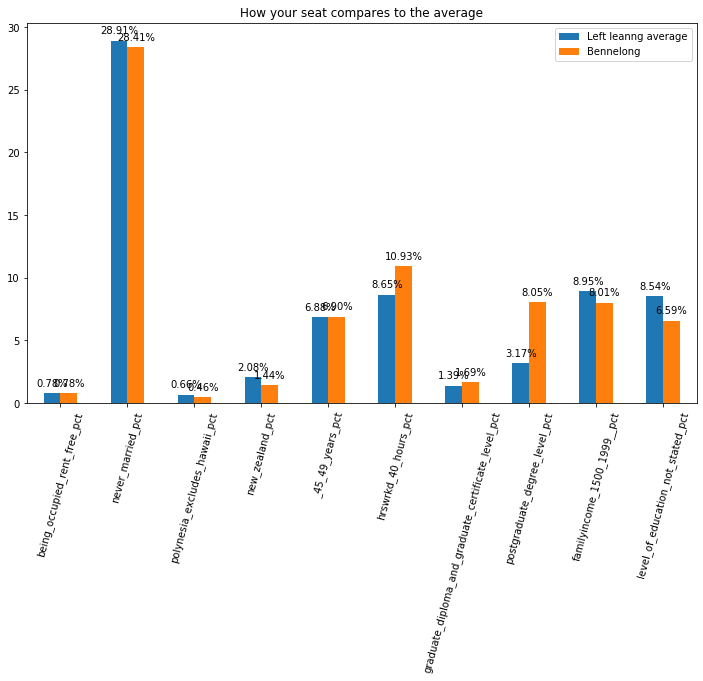

In [25]:
#This function takes in an electorate name, gives out the probability of it being left or right leaning and states
#whether the seat in the actual election voted left or right (refer to docstring for more info)
md.finder(probs_1,ced_df,c_coefs)

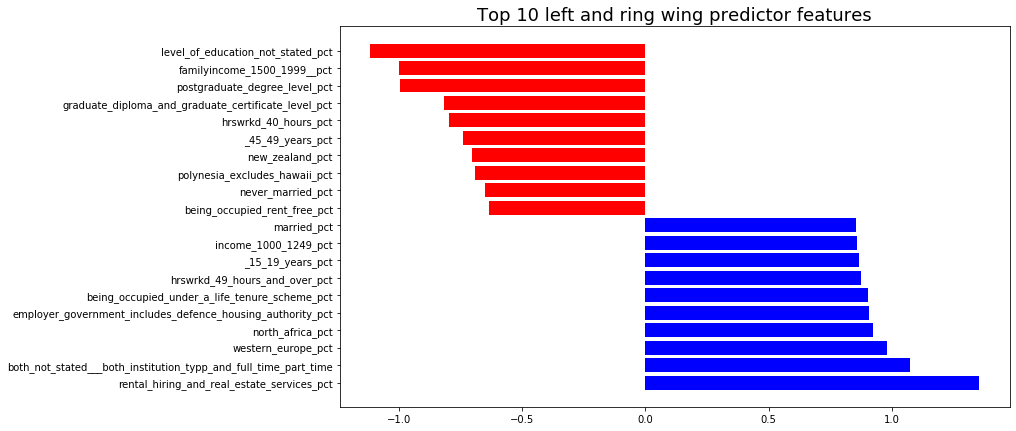

In [26]:
#Graphing the top and bottom 10 right and left coefficients that predict a left or right leaning seats
md.coef_grapher(c_coefs,title='Top 10 left and ring wing predictor features')

* The end result of this modeling process is complete, I now have my top 10 left and right leaning coefficients. And while I am pleased with the results, the presence of some features like 'education not stated' kind of take away the meaning of the coefficients. I believe some feature engineering and lasso will solve this problem and give a bit more insight into predictors of left/right leaningness. 

### Model 2: Logistic Regression with Gridsearched hyperparameters saga

* For this model I will only be grid searching for the optimal hyper parameters for Sklearn's logistic regression model. I will be doing two grid searches as some of the elastic net and regularisation parameters only work with certani solvers. This way, I am encompassing all sorts of combinations to get the best model. They will be scored purely on their accuracy.

In [27]:
#Defining the hyper paramters, only for 'elastic net' and the 'saga' solver
lr_en_params = {
    'penalty':['elasticnet'],
    'solver':['saga'],
    #Searching for regularisation strength
    'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    #Searching for best lasso/ridge ratio
    'l1_ratio':np.linspace(0.01,1.0,100),
}

In [28]:
#Defining the model object
lr_en_gs = GridSearchCV(lr,lr_en_params,cv=5,verbose=1,n_jobs=-1)

In [29]:
#Fitting it to pre defined X and Y's
lr_en_gs.fit(X,y)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1161 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1611 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2161 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2811 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3561 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,

In [30]:
#Outputting the best parameters
lr_en_gs.best_params_

{'C': 0.1,
 'l1_ratio': 0.09999999999999999,
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [31]:
#Scoring based on best estimator from above
scores_acc = cross_val_score(lr_en_gs.best_estimator_,X,y,cv=10,scoring='accuracy')
scores_prec = cross_val_score(lr_en_gs.best_estimator_,X,y,cv=10,scoring='precision')
scores_rec = cross_val_score(lr_en_gs.best_estimator_,X,y,cv=10,scoring='recall')
scores_f1 = cross_val_score(lr_en_gs.best_estimator_,X,y,cv=10,scoring='f1')

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv acc mean:',np.mean(scores_acc),'std:',np.std(scores_acc))
print('Model cv prec mean:',np.mean(scores_prec),'std:',np.std(scores_prec))
print('Model cv rec mean:',np.mean(scores_rec),'std:',np.std(scores_rec))
print('Model cv f1 mean:',np.mean(scores_f1),'std:',np.std(scores_f1))

Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv acc mean: 0.8481938470511045 std: 0.028679147169898486
Model cv prec mean: 0.8598604529450423 std: 0.027001498528476664
Model cv rec mean: 0.8663563829787234 std: 0.04867992077862005
Model cv f1 mean: 0.862345658311068 std: 0.029611111624242063


* With tuned hyper parameters we can see that the model with a random 10 fold cross validation is performing a bit worse than the original. This isn't promising so far, but let's compare to how to predicts the 2019 election.

#### Logistic Regression with Gridsearched hyperparameters saga: 2019 prediction

* Now I'll be taking a deeper look at how this model predicts the 2019 federal election.

In [32]:
#Fitting the best estimator model with the test/train data above
mod_gs = lr_en_gs.best_estimator_.fit(X_train,y_train)

In [33]:
#New prediction values
y_pred_gs = mod_gs.predict(X_test)

In [34]:
#Cross validating based on state folds like above
state_folds_gs = md.custom_scorer('stateab',states,d_f=ced_df,dp=feats_to_excl,mod=lr_en_gs.best_estimator_)

acc_mean_gs = state_folds_gs['accuracy'].mean()
acc_std_gs = state_folds_gs['accuracy'].std()

rec_mean_gs = state_folds_gs['recall'].mean()
rec_std_gs = state_folds_gs['recall'].std()

prec_mean_gs = state_folds_gs['precision'].mean()
prec_std_gs = state_folds_gs['precision'].std()

f1_mean_gs = state_folds_gs['f1'].mean()
f1_std_gs = state_folds_gs['f1'].std()

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on states acc mean:',acc_mean_gs,'std:',acc_std_gs)
print('Model cv on states prec mean:',rec_mean_gs,'std:',rec_std_gs)
print('Model cv on states rec mean:',prec_mean_gs,'std:',prec_std_gs)
print('Model cv on states f1 mean:',f1_mean_gs,'std:',f1_std_gs)

Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on states acc mean: 0.8005438693765551 std: 0.1046692101701281
Model cv on states prec mean: 0.5107538987264684 std: 0.43173562685684275
Model cv on states rec mean: 0.5389163301209552 std: 0.4544928319623167
Model cv on states f1 mean: 0.8277357210690545 std: 0.029355021706257842


In [35]:
state_folds_gs

,accuracy,recall,precision,f1
NSW,0.780142,0.891156,0.740113,0.808642
VIC,0.844037,0.979381,0.748031,0.848214
QLD,0.738636,0.700787,0.917526,0.794643
WA,0.761364,0.750000,0.905660,0.820513
SA,0.875000,0.764706,1.000000,0.866667
TAS,0.655172,0.000000,0.000000,NaN
NT,0.750000,0.000000,0.000000,NaN
ACT,1.000000,0.000000,0.000000,NaN


* We can see already a dramatic improvement in the model's predicting accuracy across state folds, which much less variance between the states and a higher minimum accuracy for Queensland.


* The scoring emphasis what I had mentioned above, with a much higher average score and lower variance.

In [36]:
election_folds_gs = md.custom_scorer('year',election_years,d_f=ced_df,dp=feats_to_excl,mod=lr_en_gs.best_estimator_)

acc_mean_gs_e = election_folds_gs['accuracy'].mean()
acc_std_gs_e = election_folds_gs['accuracy'].std()

rec_mean_gs_e = election_folds_gs['recall'].mean()
rec_std_gs_e = election_folds_gs['recall'].std()

prec_mean_gs_e = election_folds_gs['precision'].mean()
prec_std_gs_e = election_folds_gs['precision'].std()

f1_mean_gs_e = election_folds_gs['f1'].mean()
f1_std_gs_e = election_folds_gs['f1'].std()

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on elections acc mean:',acc_mean_gs_e,'std:',acc_std_gs_e)
print('Model cv on elections prec mean:',rec_mean_gs_e,'std:',rec_std_gs_e)
print('Model cv on elections rec mean:',prec_mean_gs_e,'std:',prec_std_gs_e)
print('Model cv on elections f1 mean:',f1_mean_gs_e,'std:',f1_std_gs_e)

Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on elections acc mean: 0.822500896760035 std: 0.05847796527088266
Model cv on elections prec mean: 0.8227626894684876 std: 0.15582282308678333
Model cv on elections rec mean: 0.8677718791456929 std: 0.08993214815817456
Model cv on elections f1 mean: 0.8297516788819815 std: 0.07031618804809524


In [37]:
election_folds_gs

,accuracy,recall,precision,f1
2004,0.717241,0.534091,1.000000,0.696296
2007,0.835616,0.954545,0.750000,0.840000
2010,0.842466,0.905405,0.807229,0.853503
2013,0.837838,0.795699,0.936709,0.860465
2016,0.893333,0.936709,0.870588,0.902439
2019,0.808511,0.810127,0.842105,0.825806


* The predictability of election folds has actually gone down as an average score, but the accuracy of predicting 2019 has gone up, a slight improvement but not ideal.

In [38]:
md.confusion_matrix(y_test,y_pred_gs)

,Predicted positive,Predicted negative
Actual Positive,64,15
Actual Negative,12,50


* Although the score change has been minimal, the confusion matrix reveals that the model has a far more balanced approach to false right and false left wing predictions. It is still slightly worse at predicting right wing seats, but far more balanced. I believe this is because the first model was over-fitted, demonstrated by how variant the state fold predictions were.

In [39]:
#Assigning a new probability table, based on the above model (refer to docstring)
probs_2 = md.probability_table(mod_gs,X_test,y_test,ref_df=ced_df)
probs_2

,is_left_pct,is_right_pct,electorate,predicted,actual
0,86.0638,13.9362,Adelaide,left,left
1,46.3280,53.6720,Aston,right,right
2,62.6512,37.3488,Ballarat,left,left
3,56.9380,43.0620,Banks,left,right
4,3.0498,96.9502,Barker,right,right
5,77.2570,22.7430,Barton,left,left
6,85.1454,14.8546,Bass,left,right
7,65.9269,34.0731,Bendigo,left,left
8,16.7924,83.2076,Bennelong,right,right
9,2.2034,97.7966,Berowra,right,right


In [40]:
#Printing the mean probability of left/right as a gauge for how confident the model was in predicting each class
print('Mean left leaning probability is {0:.2f}%'.format(probs_2['is_left_pct'].mean()))
print('Mean right leaning probability is {0:.2f}%'.format(probs_2['is_right_pct'].mean()))

Mean left leaning probability is 44.29%
Mean right leaning probability is 55.71%


* The model is much more equally confident at predicting left or right leaning seats.

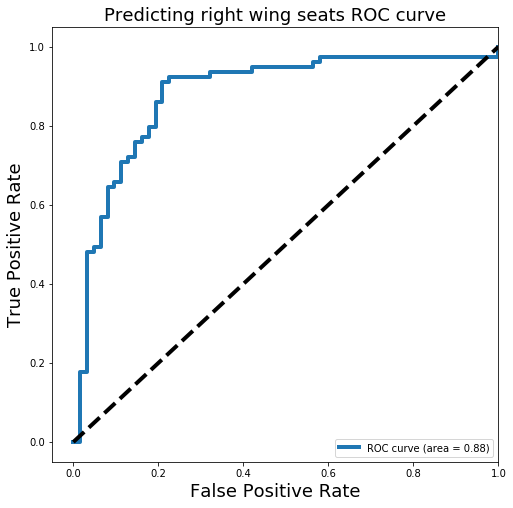

In [41]:
#Making a ROC curve function with AUC calculation
md.roc_curve_grapher(y_test,probs_2['is_right_pct'],title='Predicting right wing seats ROC curve')

* We can see a minimal difference between the previous mode, with an AUC of about 0.92 (compared to 0.91). 

In [42]:
#Ouputting the coefficients to a new data frame zipped with the coefficient names
c_coefs_best = pd.DataFrame(dict(zip(X_train.columns,lr_en_gs.best_estimator_.coef_[0])),index=['Value']).T
c_coefs_best['ABS_Value'] = c_coefs_best['Value'].apply(abs)
c_coefs_best['Probability'] = c_coefs_best['Value'].apply(md.logit_convert)
c_coefs_best.sort_values(by='Value',ascending=False)

,Value,ABS_Value,Probability
married_pct,0.112892,0.112892,0.528193
agriculture_forestry_and_fishing_pct,0.112860,0.112860,0.528185
christianity_pct,0.099556,0.099556,0.524869
year_11_or_equivalent_pct,0.083918,0.083918,0.520967
volunteer_pct,0.083393,0.083393,0.520836
worked_at_home_pct,0.075805,0.075805,0.518942
englishprof_not_applicable_pct,0.074210,0.074210,0.518544
couple_family_with_no_children_pct,0.071715,0.071715,0.517921
hrswrkd_49_hours_and_over_pct,0.070688,0.070688,0.517665
not_australian_pct,0.060820,0.060820,0.515200


Enter your electorate name: wentworth
The seat of Wentworth was predicted to have a 96.7529 % probability of being right leaning
The 2019 election saw Wentworth as voting right leaning

How your seat scored on top 10 predictors right leaning predictors:
------
married_pct feature was in the 3.95th percentile.
agriculture_forestry_and_fishing_pct feature was in the 9.21th percentile.
christianity_pct feature was in the 2.63th percentile.
year_11_or_equivalent_pct feature was in the 1.32th percentile.
volunteer_pct feature was in the 57.89th percentile.
worked_at_home_pct feature was in the 81.58th percentile.
englishprof_not_applicable_pct feature was in the 32.89th percentile.
couple_family_with_no_children_pct feature was in the 22.37th percentile.
hrswrkd_49_hours_and_over_pct feature was in the 99.34th percentile.
not_australian_pct feature was in the 82.89th percentile.


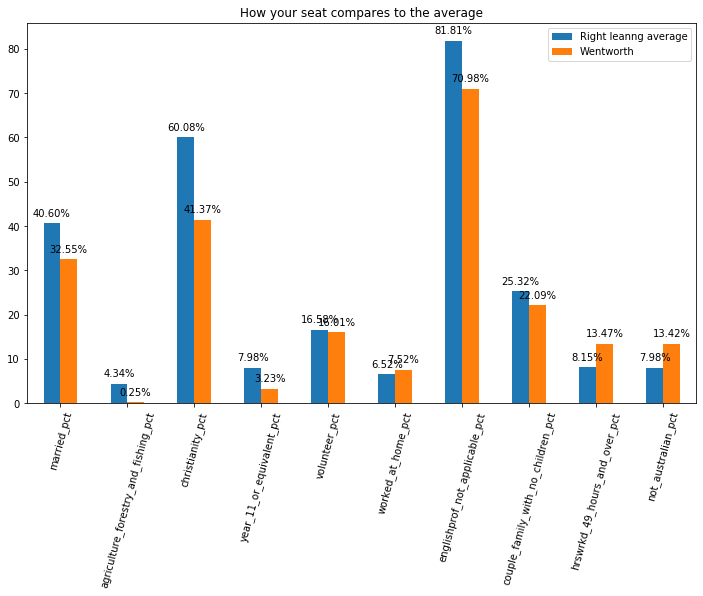

In [43]:
#Calling the finder function again (refer to docstring)
md.finder(probs_2,ced_df,c_coefs_best)

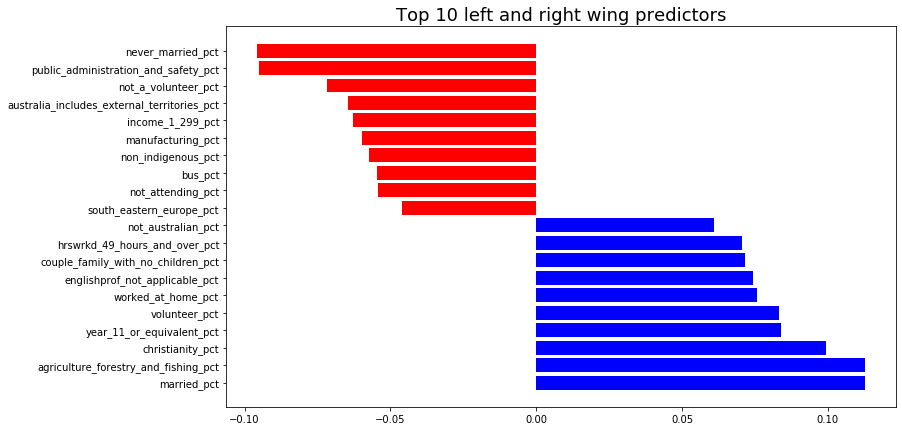

In [44]:
#Outputting to a coefficient graph (refer to doc string)
md.coef_grapher(c_coefs_best,title='Top 10 left and right wing predictors')

* Now with the final results, we can see that the coefficients are a bit more meaningful, and there is a clear difference between left and right wing predictors, with the obvious Christianity and marriage proportions being the top right wing predictors. There have been promising improvements, but the next hyperparamter tuning might be even more effective. 

### Model 3: Logistic Regression with Gridsearched hyperparameters other solvers

* The final hyper parameter tuning model will be with the rest of the solvers, I will only be gridsearching the ridge penalty as that is the only penalty compatible with all the listed solvers below.

In [45]:
#Defining the parameters to be gridsearched over
lr_params = {
    'penalty':['l2'],
    'solver':['newton-cg','saga','lbfgs','sag'],
    'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

In [46]:
#Defining the gridsearch object
lr_gs = GridSearchCV(lr,lr_params,cv=5,verbose=1,n_jobs=-1)

In [47]:
#Fitting it to the pre defined Xs and Ys
lr_gs.fit(X,y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   38.3s finished
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'saga', 'lbfgs', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [50]:
#Scoring based on best estimator from above
scores_acc = cross_val_score(lr_gs.best_estimator_,X,y,cv=10,scoring='accuracy')
scores_prec = cross_val_score(lr_gs.best_estimator_,X,y,cv=10,scoring='precision')
scores_rec = cross_val_score(lr_gs.best_estimator_,X,y,cv=10,scoring='recall')
scores_f1 = cross_val_score(lr_gs.best_estimator_,X,y,cv=10,scoring='f1')

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv acc mean:',np.mean(scores_acc),'std:',np.std(scores_acc))
print('Model cv prec mean:',np.mean(scores_prec),'std:',np.std(scores_prec))
print('Model cv rec mean:',np.mean(scores_rec),'std:',np.std(scores_rec))
print('Model cv f1 mean:',np.mean(scores_f1),'std:',np.std(scores_f1))

Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv acc mean: 0.8914938276105075 std: 0.021440839555776133
Model cv prec mean: 0.8976404796032126 std: 0.02576566301171311
Model cv rec mean: 0.906072695035461 std: 0.03751238939075907
Model cv f1 mean: 0.9011202439519348 std: 0.02046081622941085


* We can see that this model is already performing in line with the original, but we will see how it goes with the other methods of evaluation.

**Predicting 2019: Logistic Regression with Gridsearched hyperparameters other solvers**

* Now I'll apply this model to predicting the 2019 election

In [51]:
#Fitting the model to the training data
lr_best_mod = lr_gs.best_estimator_.fit(X_train,y_train)

In [52]:
#Generating the predictions
y_pred_gs2 = lr_best_mod.predict(X_test)

In [53]:
#Getting the confusion matrix (refer to docstring)
md.confusion_matrix(y_test,y_pred_gs2)

,Predicted positive,Predicted negative
Actual Positive,63,16
Actual Negative,6,56


* As we can see, this model has surpassed the previous two in false left/right wing errors. While there is still a bit of a skew towards incorrectly predicting left wing seats when they voted right, it is far less imbalanced, suggesting that the model isn't as overfitted. 

In [54]:
state_folds_gs2 = md.custom_scorer('stateab',states,d_f=ced_df,dp=feats_to_excl,mod=lr_gs.best_estimator_)

acc_mean_gs2 = state_folds_gs2['accuracy'].mean()
acc_std_gs2 = state_folds_gs2['accuracy'].std()

rec_mean_gs2 = state_folds_gs2['recall'].mean()
rec_std_gs2 = state_folds_gs2['recall'].std()

prec_mean_gs2 = state_folds_gs2['precision'].mean()
prec_std_gs2 = state_folds_gs2['precision'].std()

f1_mean_gs2 = state_folds_gs2['f1'].mean()
f1_std_gs2 = state_folds_gs2['f1'].std()

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on states acc mean:',acc_mean_gs2,'std:',acc_std_gs2)
print('Model cv on states prec mean:',rec_mean_gs2,'std:',rec_std_gs2)
print('Model cv on states rec mean:',prec_mean_gs2,'std:',prec_std_gs2)
print('Model cv on states f1 mean:',f1_mean_gs2,'std:',f1_std_gs2)

Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on states acc mean: 0.7190007553187155 std: 0.2208956679910596
Model cv on states prec mean: 0.46809883385684414 std: 0.4124454012426917
Model cv on states rec mean: 0.5292808599681493 std: 0.44708855079031085
Model cv on states f1 mean: 0.7726682374207645 std: 0.08259067474243889


In [55]:
state_folds_gs2

,accuracy,recall,precision,f1
NSW,0.794326,0.829932,0.787097,0.807947
VIC,0.802752,0.969072,0.701493,0.813853
QLD,0.590909,0.472441,0.923077,0.625000
WA,0.727273,0.796875,0.822581,0.809524
SA,0.828125,0.676471,1.000000,0.807018
TAS,0.758621,0.000000,0.000000,NaN
NT,0.250000,0.000000,0.000000,NaN
ACT,1.000000,0.000000,0.000000,NaN


* While not as good as the previous model at predicting states, it is doing a slightly better job at predicting QLD, which is something the first model wasn't doing well. Although NT is scoring very low, its relative lack of electorates will not make it so important for evaluating the model as a whole. 

In [56]:
election_folds_egs2 = md.custom_scorer('year',election_years,d_f=ced_df,dp=feats_to_excl,mod=lr_gs.best_estimator_)

acc_mean_egs2 = election_folds['accuracy'].mean()
acc_std_egs2 = election_folds['accuracy'].std()

rec_mean_egs2 = election_folds['recall'].mean()
rec_std_egs2 = election_folds['recall'].std()

prec_mean_egs2 = election_folds['precision'].mean()
prec_std_egs2 = election_folds['precision'].std()

f1_mean_egs2 = election_folds['f1'].mean()
f1_std_egs2 = election_folds['f1'].std()

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on years acc mean:',acc_mean_egs2,'std:',acc_std_egs2)
print('Model cv on years prec mean:',rec_mean_egs2,'std:',rec_std_egs2)
print('Model cv on years rec mean:',prec_mean_egs2,'std:',prec_std_egs2)
print('Model cv on years f1 mean:',f1_mean_egs2,'std:',f1_std_egs2)

Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on years acc mean: 0.8358093823328147 std: 0.09175517917817386
Model cv on years prec mean: 0.821032171226128 std: 0.1932947488903248
Model cv on years rec mean: 0.8906606897876856 std: 0.08389361158249492
Model cv on years f1 mean: 0.8377634000132117 std: 0.10200229493395266


In [57]:
election_folds_egs2

,accuracy,recall,precision,f1
2004,0.751724,0.602273,0.981481,0.746479
2007,0.815068,0.969697,0.719101,0.825806
2010,0.924658,0.945946,0.909091,0.927152
2013,0.871622,0.838710,0.951220,0.891429
2016,0.913333,0.974684,0.875000,0.922156
2019,0.843972,0.797468,0.913043,0.851351


* For predicting based on election years, this model has by far the best score, not only in terms of the average cross validated score, but also in terms of predicting 2019. A 6% increase in accuracy from the original model. Going forward, this will be the main model I will use and demonstrate the coefficients.

In [58]:
probs_3 = md.probability_table(lr_best_mod,X_test,y_test,ref_df=ced_df)
probs_3

,is_left_pct,is_right_pct,electorate,predicted,actual
0,99.1591,0.8409,Adelaide,left,left
1,42.5418,57.4582,Aston,right,right
2,97.8921,2.1079,Ballarat,left,left
3,42.3214,57.6786,Banks,right,right
4,0.0119,99.9881,Barker,right,right
5,64.2349,35.7651,Barton,left,left
6,93.6639,6.3361,Bass,left,right
7,96.8742,3.1258,Bendigo,left,left
8,21.4555,78.5445,Bennelong,right,right
9,0.1302,99.8698,Berowra,right,right


In [59]:
#Printing the mean probability of left/right as a gauge for how confident the model was in predicting each class
print('Mean left leaning probability is {0:.2f}%'.format(probs_3['is_left_pct'].mean()))
print('Mean right leaning probability is {0:.2f}%'.format(probs_3['is_right_pct'].mean()))

Mean left leaning probability is 54.28%
Mean right leaning probability is 45.72%


* We can see that the probability of predicting left/right leaning seats is far more balanced than the original model. With slightly more confidence in predicting left leaning seats over right leaning seats. 

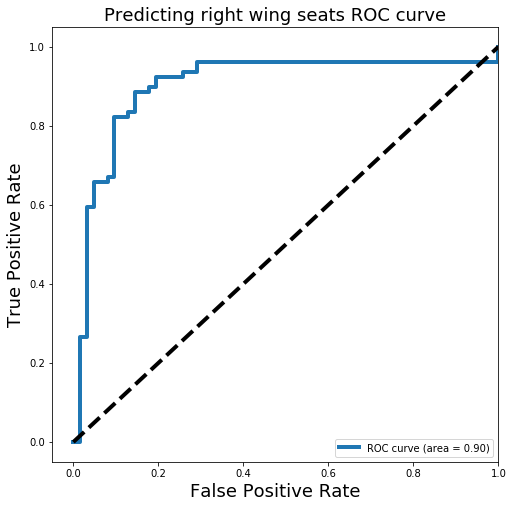

In [60]:
md.roc_curve_grapher(y_test,probs_3['is_right_pct'],title='Predicting right wing seats ROC curve')

* The AUC is a bit lower than the other models, but its accuracy in predicting 2019 is the best so far.

In [61]:
#Putting the coefficients into a data frame, zipped up with the feature names
c_coefs_lr = pd.DataFrame(dict(zip(X_train.columns,lr_best_mod.coef_[0])),index=['Value']).T
c_coefs_lr['ABS_Value'] = c_coefs_lr['Value'].apply(abs)
#Applying the logit convert function to get the probabilities
c_coefs_lr['Probability'] = c_coefs_lr['Value'].apply(md.logit_convert)
c_coefs_lr.sort_values(by='Value',ascending=False)

,Value,ABS_Value,Probability
both_not_stated___both_institution_typp_and_full_time_part_time,0.390527,0.390527,0.596410
wholesale_trade_pct,0.379492,0.379492,0.593751
retail_trade_pct,0.348596,0.348596,0.586277
year_11_or_equivalent_pct,0.344731,0.344731,0.585339
married_pct,0.334766,0.334766,0.582918
hrswrkd_49_hours_and_over_pct,0.313721,0.313721,0.577793
rental_hiring_and_real_estate_services_pct,0.313354,0.313354,0.577704
western_europe_pct,0.289213,0.289213,0.571804
mortgage_3000_3999_pct,0.260763,0.260763,0.564824
employer_government_includes_defence_housing_authority_pct,0.235651,0.235651,0.558642


Enter your electorate name: warringah
The seat of Warringah was predicted to have a 99.6275 % probability of being right leaning
The 2019 election saw Warringah as voting right leaning

How your seat scored on top 10 predictors right leaning predictors:
------
both_not_stated___both_institution_typp_and_full_time_part_time feature was in the 41.45th percentile.
wholesale_trade_pct feature was in the 82.89th percentile.
retail_trade_pct feature was in the 6.58th percentile.
year_11_or_equivalent_pct feature was in the 9.21th percentile.
married_pct feature was in the 61.18th percentile.
hrswrkd_49_hours_and_over_pct feature was in the 96.05th percentile.
rental_hiring_and_real_estate_services_pct feature was in the 97.37th percentile.
western_europe_pct feature was in the 98.68th percentile.
mortgage_3000_3999_pct feature was in the 91.45th percentile.
employer_government_includes_defence_housing_authority_pct feature was in the 46.71th percentile.


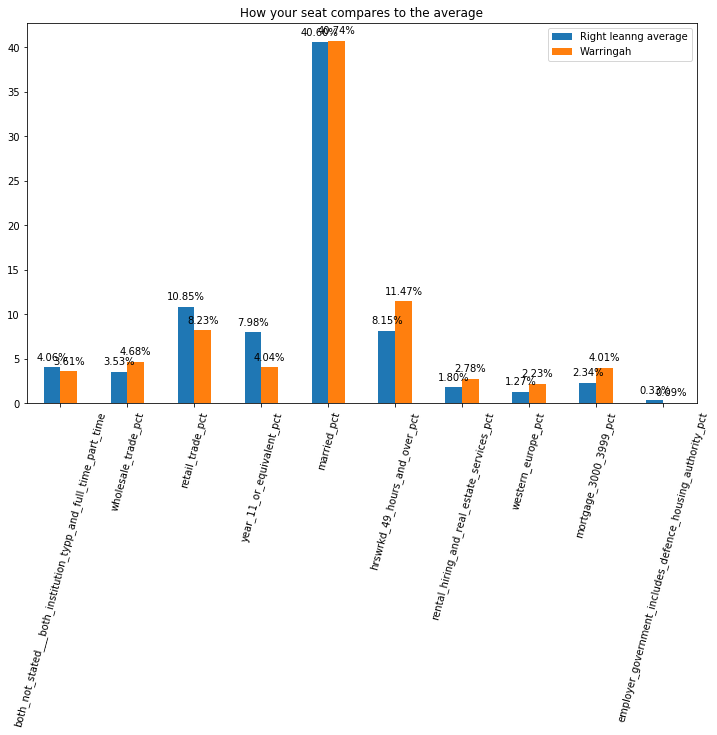

In [62]:
#Calling the finder function (refer to docstring)
md.finder(probs_3,ced_df,c_coefs_lr)

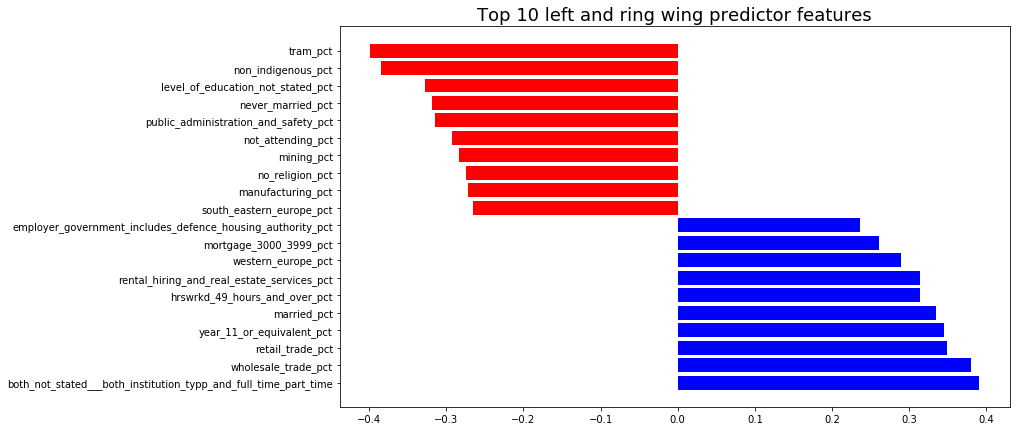

In [63]:
#Calling the coefficient grapher (refer to docstring)
md.coef_grapher(c_coefs_lr,title='Top 10 left and ring wing predictor features')

* The coefficients are looking a lot better than the previous two, with some very clear differences between top left and right wing predictors. Surprisingly, 'mining' is in the top left wing predictor, but would make sense as many working class voters do work in the mining industry and tend to be highly unionised, being natural candidates for voting Labor. 


* The percentage of tram users in an electorate was also a huge predictor of left leaning electorates, no surprise as Melbourne has a lot of electorates which vote left.


* From this point, I believe that this model will be the standard I will use for presentations and demonstrations, but I will go ahead and test how the model will work with some manual feature engineering.

### Model 4: Logistic Regression manual cleaning of coefficients

**Dealing with multi collinearity**

* In cleaning the data, I will first clean up the highly correlated features.

In [64]:
for col in ced_df:
    if 'both_not' in col:
        print(col)

both_not_stated___both_institution_typp_and_full_time_part_time


In [65]:
#Defining a new set of data for this model
data2 = ced_df.drop(columns=feats_to_excl)

In [66]:
#Using the corr finder function to find highly positively correlated features
md.corr_finder(data2,1,0.8).T

domesticwrk_not_applicable_pct             not_applicable_pct  \
                        not_applicable_pct domesticwrk_not_applicable_pct   
Correlation                       0.999572                       0.999572   

                 income_not_applicable_pct domesticwrk_not_applicable_pct  \
            domesticwrk_not_applicable_pct      income_not_applicable_pct   
Correlation                       0.997855                       0.997855   

            income_not_applicable_pct        not_applicable_pct  \
                   not_applicable_pct income_not_applicable_pct   
Correlation                  0.996795                  0.996795   

            level_of_education_not_stated_pct  \
                   domesticwrk_not_stated_pct   
Correlation                           0.97949   

                   domesticwrk_not_stated_pct not_applicable_pct  \
            level_of_education_not_stated_pct     _5_9_years_pct   
Correlation                           0.97949            0.97855   

                _5_9_years_pct domesticwrk_not_applicable_pct  \
            not_applicable_pct                 _5_9_years_pct   
Correlation            0.97855                       0.975316   

                            _5_9_years_pct        not_stated_pct  \
            domesticwrk_not_applicable_pct income_not_stated_pct   
Correlation                       0.975316              0.971243   

            income_not_stated_pct englishprof_not_at_all_pct  \
                   not_stated_pct   englishprof_not_well_pct   
Correlation              0.971243                   0.970649   

              englishprof_not_well_pct mortgage_450_599_pct  \
            englishprof_not_at_all_pct mortgage_600_799_pct   
Correlation                   0.970649             0.966006   

            mortgage_600_799_pct            _5_9_years_pct  \
            mortgage_450_599_pct income_not_applicable_pct   
Correlation             0.966006                  0.965656   

            income_not_applicable_pct  \
                       _5_9_years_pct   
Correlation                  0.965656   

            englishprof_not_stated___both_language_lanp_and_proficiency_eng  \
                                                             not_stated_pct   
Correlation                                           0.964604                

                                                             not_stated_pct  \
            englishprof_not_stated___both_language_lanp_and_proficiency_eng   
Correlation                                           0.964604                

                                                      income_not_stated_pct  \
            englishprof_not_stated___both_language_lanp_and_proficiency_eng   
Correlation                                           0.963998                

            englishprof_not_stated___both_language_lanp_and_proficiency_eng  \
                                                      income_not_stated_pct   
Correlation                                           0.963998                

            englishprof_very_well_pct      englishprof_well_pct  \
                 englishprof_well_pct englishprof_very_well_pct   
Correlation                   0.96093                   0.96093   

            _90_94_years_pct _95_99_years_pct bachelor_degree_level_pct  \
            _95_99_years_pct _90_94_years_pct year_12_or_equivalent_pct   
Correlation         0.959089         0.959089                  0.958112   

            year_12_or_equivalent_pct postgraduate_degree_level_pct  \
            bachelor_degree_level_pct     bachelor_degree_level_pct   
Correlation                  0.958112                      0.952678   

                bachelor_degree_level_pct mortgage_300_449_pct  \
            postgraduate_degree_level_pct mortgage_800_999_pct   
Correlation                      0.952678             0.950793   

            mortgage_800_999_pct englishprof_not_well_pct  \
            mortgage_300_449_pct     english

In [67]:
#Using the corr finder function to find highly negatively correlated features
md.corr_finder(data2,-0.8,-1).T

,_35_39_years_pct,_70_74_years_pct,improvised_home_tent_sleepers_out_pct,non_indigenous_pct,rent_not_applicable_pct,real_estate_agent_pct,_35_39_years_pct,_60_64_years_pct,englishprof_not_well_pct,australia_includes_external_territories_pct,year_12_or_equivalent_pct,domesticwrk_30_hours_or_more_pct,year_10_or_equivalent_pct,year_12_or_equivalent_pct,separate_house_pct,real_estate_agent_pct,englishprof_not_applicable_pct,familyincome_nil_income_pct,income_2000_plus_pct,familyincome_400_799_pct,domesticwrk_less_than_5_hours_pct,familyincome_400_799_pct,_65_69_years_pct,_35_39_years_pct,income_300_399_pct,internet_accessed_from_dwelling_pct,familyincome_400_799_pct,income_1250_1499_pct,does_not_have_need_for_assistance_with_core_activities_pct,not_stated_pct,year_12_or_equivalent_pct,familyincome_400_799_pct,married_pct,never_married_pct,income_1250_1499_pct,income_300_399_pct,australian_pct,_25_29_years_pct,hrswrkd_not_applicable_pct,hrswrkd_41_48_hours_pct,internet_accessed_from_dwelling_pct,rent_100_199_pct,income_1500_1999_pct,familyincome_1_399_pct,domesticwrk_15_to_29_hours_pct,_30_34_years_pct,_25_29_years_pct,domesticwrk_15_to_29_hours_pct,familyincome_1250_1499_pct,income_1500_1999_pct,flat_unit_or_apartment_in_a_three_storey_block_pct,separate_house_pct,did_not_go_to_school_pct,englishprof_not_applicable_pct,income_not_stated_pct,does_not_have_need_for_assistance_with_core_activities_pct,familyincome_400_799_pct,familyincome_3500_3999__pct,separate_house_pct,flat_unit_or_apartment_in_a_four_or_more_storey_block_pct,year_9_or_equivalent_pct,year_12_or_equivalent_pct,employed_worked_full_time_pct,not_in_the_labour_force_pct,mortgage_2000_2199_pct,mortgage_not_applicable_pct,inadequately_described_pct,employed_away_from_work_pct,englishprof_not_stated___both_language_lanp_and_proficiency_eng,does_not_have_need_for_assistance_with_core_activities_pct,income_1500_1999_pct,income_300_399_pct,australia_includes_external_territories_pct,englishprof_well_pct,income_1500_1999_pct,income_1_299_pct,englishprof_not_stated___language_lanp_stated_proficiency_engp_,englishprof_not_applicable_pct,australia_includes_external_territories_pct,englishprof_very_well_pct,not_australian_pct,australia_includes_external_territories_pct,internet_not_accessed_from_dwelling_pct,internet_accessed_from_dwelling_pct,internet_not_accessed_from_dwelling_pct,income_1500_1999_pct,aboriginal_pct,non_indigenous_pct,employed_worked_full_time_pct,hrswrkd_not_applicable_pct,couple_family_with_children_pct,familyincome_not_applicable_pct,englishprof_not_at_all_pct,englishprof_not_applicable_pct,not_australian_pct,australian_pct,englishprof_not_applicable_pct,englishprof_not_well_pct,rented_pct,rent_not_applicable_pct,englishprof_not_applicable_pct,englishprof_very_well_pct,englishprof_not_applicable_pct,englishprof_well_pct,owned_with_a_mortgage_pct,mortgage_not_applicable_pct
,_70_74_years_pct,_35_39_years_pct,non_indigenous_pct,improvised_home_tent_sleepers_out_pct,real_estate_agent_pct,rent_not_applicable_pct,_60_64_years_pct,_35_39_years_pct,australia_includes_external_territories_pct,englishprof_not_well_pct,domesticwrk_30_hours_or_more_pct,year_12_or_equivalent_pct,year_12_or_equivalent_pct,year_10_or_equivalent_pct,real_estate_agent_pct,separate_house_pct,familyincome_nil_income_pct,englishprof_not_applicable_pct,familyincome_400_799_pct,income_2000_plus_pct,familyincome_400_799_pct,domesticwrk_less_than_5_hours_pct,_35_39_years_pct,_65_69_years_pct,internet_accessed_from_dwelling_pct,income_300_399_pct,income_1250_1499_pct,familyincome_400_799_pct,not_stated_pct,does_not_have_need_for_assistance_with_core_activities_pct,familyincome_400_799_pct,year_12_or_equivalent_pct,never_married_pct,married_pct,income_300_399_pct,income_1250_1499_pct,_25_29_years_pct,australian_pct,hrswrkd_41_48_hours_pct,hrswrkd_not_applicable_pct,rent_100_199_pct,internet_accessed_from_dwelling_pct,familyincome_1_399_pct,income_1500_1999_pct,_30_34_years_pct,domesticwrk_15_to_29_

In [68]:
#Removing all features that contain the name 'not applicable' and 'not stated' in them
na_cols = [col for col in data2.columns if 'not_applicable' in col or 'not_stated' in col]
data2.drop(columns=na_cols,inplace=True)

In [69]:
#Merging education features into one feature that is year 12 and above (they were all highly correlated)
data2['year_12_university_educated_pct'] = data2['year_12_or_equivalent_pct'] + data2['bachelor_degree_level_pct'] + data2['graduate_diploma_and_graduate_certificate_level_pct'] + data2['postgraduate_degree_level_pct']

#Dropping the columns that have been merged
data2.drop(columns=['year_12_or_equivalent_pct','bachelor_degree_level_pct','graduate_diploma_and_graduate_certificate_level_pct','postgraduate_degree_level_pct'],inplace=True)

In [70]:
#Defining a new feature that sums all the vocational education into one feature
data2['vocation_education_pct'] = data2['certificate_level_pct'] + data2['advanced_diploma_and_diploma_level_pct']

#Dropping the merged columns
data2.drop(columns=['certificate_level_pct','advanced_diploma_and_diploma_level_pct'],inplace=True)

In [71]:
#Dropping all columns with 'family income' in them as they highly correlate with 'income' features
data2.drop(columns=[col for col in data2.columns if 'familyincome' in col],inplace=True)

In [72]:
#Merging and consolidating the income brackets so they are less highly correlated
data2['income_1_399_pct'] = data2[[col for col in data2.columns if 'income' in col][2:4]].sum(axis=1)
#Dropping the columns when they are done
data2.drop(columns=[col for col in data2.columns if 'income' in col][2:4],inplace=True)

data2['income_1000_1499_pct'] = data2[[col for col in data2.columns if 'income' in col][4:6]].sum(axis=1)
data2.drop(columns=[col for col in data2.columns if 'income' in col][4:6],inplace=True)

data2['income_1500_plus_pct'] = data2[[col for col in data2.columns if 'income' in col][4:6]].sum(axis=1)
data2.drop(columns=[col for col in data2.columns if 'income' in col][4:6],inplace=True)

In [73]:
#Merging the mortgage bracket columns as they are also highly correlated
data2['mortgage_1_1199_pct'] = data2[[col for col in data2.columns if 'mortgage_' in col][:7]].sum(axis=1)
data2['mortgage_1200_2599_pct'] = data2[[col for col in data2.columns if 'mortgage_' in col][7:14]].sum(axis=1)
data2['mortgage_2600_plus_pct'] = data2[[col for col in data2.columns if 'mortgage_' in col][14:18]].sum(axis=1)

data2.drop(columns=[col for col in data2.columns if 'mortgage_' in col][:18],inplace=True)

In [74]:
#Merging the age brackets so they do not correlate with each other as much
data2['_0_34_years_pct'] = data2[[col for col in data2.columns if 'years' in col][:7]].loc[:,].sum(axis=1)
data2['_35_54_years_pct'] = data2[[col for col in data2.columns if 'years' in col][7:11]].loc[:,].sum(axis=1)
data2['_55_74_years_pct'] = data2[[col for col in data2.columns if 'years' in col][11:15]].loc[:,].sum(axis=1)
data2['_75_plus_years_pct'] = data2[[col for col in data2.columns if 'years' in col][15:21]].loc[:,].sum(axis=1)

data2.drop(columns=[col for col in data2.columns if 'years' in col][:21],inplace=True)

In [75]:
#Using the custom col merger function to merge the two negative english proficiency columns into one (refer to docstring)
md.col_merger('englishprof_very_well_pct','englishprof_well_pct',data2,'englishprof_good_pct')

In [76]:
#Using the custom col merger function to merge the two positive english proficiency columns into one (refer to docstring)
md.col_merger('englishprof_not_well_pct','englishprof_not_at_all_pct',data2,'englishprof_not_good_pct')

In [77]:
#Manually defining features that I thought should be dropped as they are highly correlated and/or redundant
feats_to_drop = ['not_australian_pct','non_indigenous_pct','internet_not_accessed_from_dwelling_pct',
                 'inadequately_described_pct','never_married_pct','englishprof_not_good_pct',
                 'not_in_the_labour_force_pct', 'mainland_south_east_asia_pct','southern_asia_pct',
                 'both_aboriginal_and_torres_strait_islander_pct','hrswrkd_1_15_hours_pct',
                 'middle_east_pct','hrswrkd_16_24_hours_pct','hrswrkd_41_48_hours_pct','employer_other_employer_pct',
                 'hrswrkd_40_hours_pct','residential_park_includes_caravan_parks_and_marinas_pct',
                 'separate_house_pct','level_of_education_inadequately_described_pct']

#Dropping the aforementioned columns
data2.drop(columns=feats_to_drop,inplace=True)

**Low Variance variables**

* Now that the highly correlated features have been dealt with, I will not very quickly remove low variance features. Low variance features are those with a variance roughly less than 0.1% standard deviation. They are being removed as they do not add much to the model and can affect the output of each model.

In [78]:
#Defining the low var feats as the top 12 least variant features (all less than 0.1% std)
low_var_feats = data2.std().sort_values().head(12).index

#Dropping the defined columns
data2.drop(columns=low_var_feats,inplace=True)

**Fitting new model with cleaned up columns**

* Now that the data has been cleaned, I'll now fit a new model based on the cleaned coefficients.

In [79]:
#Putting back the 'year', 'state', and 'electorate' columns for cross validating and identifying electorates
data2['year'] = ced_df['year']
data2['state'] = ced_df['stateab']
data2['divisionnm'] = ced_df['divisionnm']

In [80]:
#Defining the new Xs after dropping the above added columns, its necessary to add those in to the original data set for
#the cross validation functions
new_X = data2.drop(columns=['is_right','year','state','divisionnm'])
new_y = data2['is_right']

In [81]:
#Defining the parameters to be gridsearched over
lr_params = {
    'penalty':['l2'],
    'solver':['newton-cg','saga','lbfgs','sag'],
    'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

In [82]:
#Defining the new logistic regression model
lr = LogisticRegression()

**Grid searching optimised hyperparameters for the new model**

* Now that I have a cleaned up data frame, I'll do a quick search for the hyper parameters like I did above to get the best scoring model.

In [83]:
#Defining the gridsearch object
lr_gs_new = GridSearchCV(lr,lr_params,cv=5,verbose=1,n_jobs=-1)

In [84]:
#Fitting the optimised model with the new X and Ys
lr_gs_new.fit(new_X,new_y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   32.3s finished
/Users/peterrudder/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'saga', 'lbfgs', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [85]:
#Scoring based on best estimator from above
scores_acc_new = cross_val_score(lr_gs_new.best_estimator_,new_X,new_y,cv=10,scoring='accuracy')
scores_prec_new = cross_val_score(lr_gs_new.best_estimator_,new_X,new_y,cv=10,scoring='precision')
scores_rec_new = cross_val_score(lr_gs_new.best_estimator_,new_X,new_y,cv=10,scoring='recall')
scores_f1_new = cross_val_score(lr_gs_new.best_estimator_,new_X,new_y,cv=10,scoring='f1')

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv acc mean:',np.mean(scores_acc_new),'std:',np.std(scores_acc_new))
print('Model cv prec mean:',np.mean(scores_prec_new),'std:',np.std(scores_prec_new))
print('Model cv rec mean:',np.mean(scores_rec_new),'std:',np.std(scores_rec_new))
print('Model cv f1 mean:',np.mean(scores_f1_new),'std:',np.std(scores_f1_new))

Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv acc mean: 0.8584864280333407 std: 0.022020327260665908
Model cv prec mean: 0.863532176076389 std: 0.016253347140842915
Model cv rec mean: 0.8809397163120567 std: 0.04863911794613197
Model cv f1 mean: 0.8713267981579575 std: 0.023054234658220894


* We can see the score is slightly below the original model, still performing very well, but election and state folds will be a far better indicator of the efficacy of this model.

In [86]:
state_folds_new = md.custom_scorer('state',states,d_f=data2,dp=['year','state','divisionnm'],mod=lr_gs_new.best_estimator_)

acc_mean_new = state_folds_new['accuracy'].mean()
acc_std_new = state_folds_new['accuracy'].std()

rec_mean_new = state_folds_new['recall'].mean()
rec_std_new = state_folds_new['recall'].std()

prec_mean_new = state_folds_new['precision'].mean()
prec_std_new = state_folds_new['precision'].std()

f1_mean_new = state_folds_new['f1'].mean()
f1_std_new = state_folds_new['f1'].std()

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on states acc mean:',acc_mean_new,'std:',acc_std_new)
print('Model cv on states prec mean:',rec_mean_new,'std:',rec_std_new)
print('Model cv on states rec mean:',prec_mean_new,'std:',prec_std_new)
print('Model cv on states f1 mean:',f1_mean_new,'std:',f1_std_new)


Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on states acc mean: 0.7842388549799284 std: 0.1505858669513627
Model cv on states prec mean: 0.530538350400839 std: 0.45033390168753545
Model cv on states rec mean: 0.5281073058294218 std: 0.44534790404720775
Model cv on states f1 mean: 0.8355895210426445 std: 0.06281843761465204


In [87]:
state_folds_new

,accuracy,recall,precision,f1
NSW,0.790780,0.918367,0.741758,0.820669
VIC,0.821101,0.979381,0.719697,0.829694
QLD,0.715909,0.653543,0.932584,0.768519
WA,0.750000,0.781250,0.862069,0.819672
SA,0.937500,0.911765,0.968750,0.939394
TAS,0.758621,0.000000,0.000000,NaN
NT,0.500000,0.000000,0.000000,NaN
ACT,1.000000,0.000000,0.000000,NaN


* A solid improvement over the original model with cleaned up coefficients, better predicting power across all states (bar Northern Territory).

In [88]:
election_folds_new = md.custom_scorer('year',election_years,d_f=data2,dp=['year','state','divisionnm'],mod=lr_gs_new.best_estimator_)

acc_mean_enew = election_folds_new['accuracy'].mean()
acc_std_enew = election_folds_new['accuracy'].std()

rec_mean_enew = election_folds_new['recall'].mean()
rec_std_enew = election_folds_new['recall'].std()

prec_mean_enew = election_folds_new['precision'].mean()
prec_std_enew = election_folds_new['precision'].std()

f1_mean_enew = election_folds_new['f1'].mean()
f1_std_enew = election_folds_new['f1'].std()

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on states acc mean:',acc_mean_enew,'std:',acc_std_enew)
print('Model cv on states prec mean:',rec_mean_enew,'std:',rec_std_enew)
print('Model cv on states rec mean:',prec_mean_enew,'std:',prec_std_enew)
print('Model cv on states f1 mean:',f1_mean_enew,'std:',f1_std_enew)


Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on states acc mean: 0.8317776463988485 std: 0.05923875010758353
Model cv on states prec mean: 0.8397630248385659 std: 0.15921252080072384
Model cv on states rec mean: 0.8714583963541976 std: 0.09204980183220494
Model cv on states f1 mean: 0.8398392401175072 std: 0.07020429029504088


In [89]:
election_folds_new

,accuracy,recall,precision,f1
2004,0.724138,0.545455,1.000000,0.705882
2007,0.821918,0.984848,0.722222,0.833333
2010,0.883562,0.918919,0.860759,0.888889
2013,0.844595,0.817204,0.926829,0.868571
2016,0.886667,0.949367,0.852273,0.898204
2019,0.829787,0.822785,0.866667,0.844156


* The elections fold predictability is also marginally better, with the 2019 prediction being the second mos accurate after model 3. This is promising going ahead as we dive deeper into testing how it performs in predicting the 2019 election.

**Predicting 2019: Logistic Regression manual cleaning of coefficients**

* I will now take the new cleaned up coefficients, and fit them to the optimised model.

In [90]:
#Defining the new training and testing data from the new data frame with cleaned up features
X_train_new = data2[data2['year'] != 2019][[col for col in data2.columns if 'is_right' not in col]]
X_train_new = X_train_new.drop(columns=['year','state','divisionnm'])
y_train_new = data2[data2['year'] != 2019]['is_right']

X_test_new = data2[data2['year'] == 2019][[col for col in data2.columns if 'is_right' not in col]]
X_test_new = X_test_new.drop(columns=['year','state','divisionnm'])
y_test_new = data2[data2['year'] == 2019]['is_right']

In [91]:
#Fitting the optimised model with the train/test data
lr_mod_new = lr_gs_new.best_estimator_.fit(X_train_new,y_train_new)

In [92]:
#Defining a new set of predictions
y_pred_new = lr_mod_new.predict(X_test_new)

In [93]:
#Generating a confusion matrix, based on the predictions above (refer to docstring)
md.confusion_matrix(y_test_new,y_pred_new)

,Predicted positive,Predicted negative
Actual Positive,65,14
Actual Negative,10,52


In [94]:
#Defining a new probability table (refer to docstring above)
probs_4 = md.probability_table(lr_mod_new,X_test_new,y_test_new,ref_df=data2)
probs_4

,is_left_pct,is_right_pct,electorate,predicted,actual
0,91.1590,8.8410,Adelaide,left,left
1,39.3665,60.6335,Aston,right,right
2,74.9973,25.0027,Ballarat,left,left
3,49.4429,50.5571,Banks,right,right
4,0.4110,99.5890,Barker,right,right
5,71.6337,28.3663,Barton,left,left
6,84.7203,15.2797,Bass,left,right
7,76.6477,23.3523,Bendigo,left,left
8,10.5162,89.4838,Bennelong,right,right
9,1.1758,98.8242,Berowra,right,right


In [95]:
#Printing the mean probability of predicting left/right leaning seats
print('Mean left leaning probability is {0:.2f}%'.format(probs_4['is_left_pct'].mean()))
print('Mean right leaning probability is {0:.2f}%'.format(probs_4['is_right_pct'].mean()))

Mean left leaning probability is 47.22%
Mean right leaning probability is 52.78%


* Interestingly enough, this model has the most balanced left/right leaning prediction strength out of all of them. This suggests a lower degree of over fitting. Promising sign.

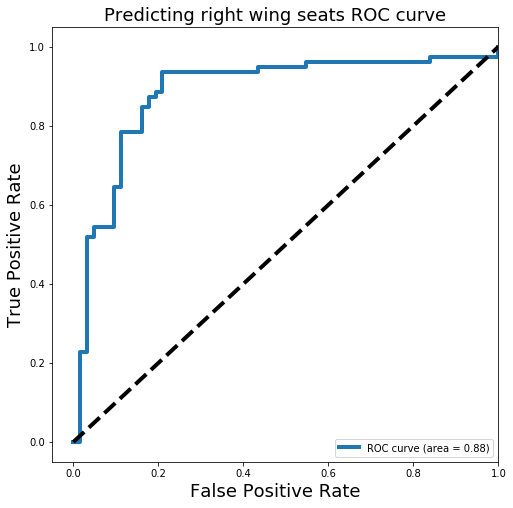

In [96]:
#Outputting the roc curve (refer to docstring)
md.roc_curve_grapher(y_test_new,probs_4['is_right_pct'],'Predicting right wing seats ROC curve')

* The AUC is the worst so far unfortunately, with a score of about 0.88. 

In [97]:
#Outputting the coefficients and their values
c_coefs_new = pd.DataFrame(dict(zip(X_train_new.columns,lr_mod_new.coef_[0])),index=['Value']).T
c_coefs_new['ABS_Value'] = c_coefs_new['Value'].apply(abs)
c_coefs_new['Probability'] = c_coefs['Value'].apply(md.logit_convert)
c_coefs_new.sort_values(by='Value',ascending=False)

,Value,ABS_Value,Probability
married_pct,0.187107,0.187107,0.701760
year_11_or_equivalent_pct,0.173208,0.173208,0.567509
aboriginal_pct,0.162287,0.162287,0.583240
hrswrkd_49_hours_and_over_pct,0.154198,0.154198,0.705511
retail_trade_pct,0.148889,0.148889,0.627888
_55_74_years_pct,0.146881,0.146881,NaN
couple_family_with_no_children_pct,0.143176,0.143176,0.513650
christianity_pct,0.141256,0.141256,0.467043
volunteer_pct,0.135702,0.135702,0.596762
agriculture_forestry_and_fishing_pct,0.119187,0.119187,0.524726


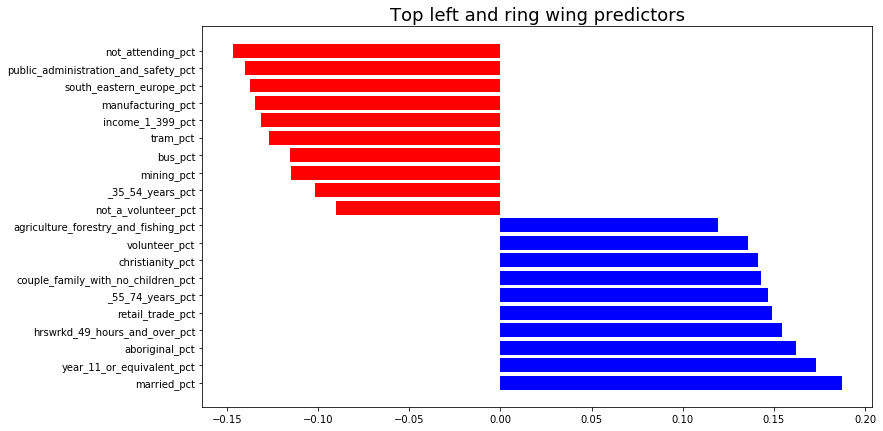

In [98]:
#Outputting the coefficients to a graph (refer to docstring)
md.coef_grapher(c_coefs_new,title='Top left and ring wing predictors')

* This model has performed far better than the previous one with cleaned up features. It has a much more balanced predictability in predicting left and right leaning electorates, with a solid accuracy overall in predicting the 2019 election.


* However, I think this is the best this model can do with the given coefficients. The removal and merging of the various features I did earlier has taken some dimensionality away from this model, so I believe that I will stick with model 3, an optimised logistic regression model that takes in all features untouched.

### Model 5: Logistic Regression with manual lasso

* The final model I will use will be using features that have been kept by a lasso regularisation (i.e. features that were not regularised to zero through the lasso process).

* I do not expect this model to score very highly compared to the others, but I will try nonetheless.

In [99]:
#Defining all the possible l1 ratios for the en cv to search over
l1_ratios = np.linspace(0.01,1.0,100)

#Defining the en cv object, with 100 alphas and 10 cross validations
en_c = ElasticNetCV(l1_ratio=l1_ratios,n_alphas=100,cv=10,verbose=1,n_jobs=-1)

#Fitting it to the original Xs and Ys
en_c.fit(X,y)

#Printing the optimal ratios for later use
print('Optimal alpha is',en_c.alpha_)
print('Optimal ratio is',en_c.l1_ratio_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

.................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal alpha is 0.5342313618367243
Optimal ratio is 0.01


In [100]:
#Fitting the new ratios with the optimal l1 ratio and alphas
en = ElasticNet(alpha=en_c.alpha_,l1_ratio=en_c.l1_ratio_)

In [101]:
#Making a dataframe that zips the coefficient names and values
en_coefs = pd.DataFrame(dict(zip(X.columns,en.fit(X,y).coef_)),index=['Value']).T
en_coefs['ABS_Value'] = en_coefs['Value'].apply(abs)
en_coefs.sort_values(by='ABS_Value',ascending=False)

,Value,ABS_Value
retail_trade_pct,0.033121,0.033121
year_11_or_equivalent_pct,0.026457,0.026457
married_pct,0.025178,0.025178
hrswrkd_49_hours_and_over_pct,0.025119,0.025119
non_indigenous_pct,-0.021946,0.021946
volunteer_pct,0.021284,0.021284
public_administration_and_safety_pct,-0.021005,0.021005
south_eastern_europe_pct,-0.020165,0.020165
couple_family_with_no_children_pct,0.019460,0.019460
never_married_pct,-0.017753,0.017753


In [102]:
#Creating a row mask that only uses the coefficients with values not equal to zero 
en_mask = en_coefs[en_coefs['Value'] != 0].index

In [103]:
#Defining the new Xs with the non zero regularised coefficients
en_X = X[en_mask]

* With the lasso coefficients now defined, I will run it through a simple logistic regression model. I am not tuning the hyper parameters with this logistic regression model, as a lot of the tuning is regularisation, so this will be just repeating that same regularisation, making it redundant to do so again.

In [104]:
#Scoring based on the simple logistic regression model
scores_acc_en = cross_val_score(lr,en_X,y,cv=10,scoring='accuracy')
scores_prec_en = cross_val_score(lr,en_X,y,cv=10,scoring='precision')
scores_rec_en = cross_val_score(lr,en_X,y,cv=10,scoring='recall')
scores_f1_en = cross_val_score(lr,en_X,y,cv=10,scoring='f1')

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv acc mean:',np.mean(scores_acc_en),'std:',np.std(scores_acc_en))
print('Model cv prec mean:',np.mean(scores_prec_en),'std:',np.std(scores_prec_en))
print('Model cv rec mean:',np.mean(scores_rec_en),'std:',np.std(scores_rec_en))
print('Model cv f1 mean:',np.mean(scores_f1_en),'std:',np.std(scores_f1_en))

Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv acc mean: 0.877765121139219 std: 0.030495960281418977
Model cv prec mean: 0.8911235568243308 std: 0.03579078655636226
Model cv rec mean: 0.887322695035461 std: 0.058247042170686415
Model cv f1 mean: 0.8875215810769973 std: 0.03076387133758827


In [105]:
#Adding these columns back into the en_X coefficients so they can be folded properly
en_X['year'] = ced_df.loc[:,'year'].values
en_X['state'] = ced_df.loc[:,'stateab'].values
en_X['is_right'] = ced_df.loc[:,'is_right'].values

In [106]:
state_folds_en = md.custom_scorer('state',states,d_f=en_X,dp=['year','state'])

acc_mean_en = state_folds_en['accuracy'].mean()
acc_std_en = state_folds_en['accuracy'].std()

rec_mean_en = state_folds_en['recall'].mean()
rec_std_en = state_folds_en['recall'].std()

prec_mean_en = state_folds_en['precision'].mean()
prec_std_en = state_folds_en['precision'].std()

f1_mean_en = state_folds_en['f1'].mean()
f1_std_en = state_folds_en['f1'].std()

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on states acc mean:',acc_mean_en,'std:',acc_std_en)
print('Model cv on states prec mean:',rec_mean_en,'std:',rec_std_en)
print('Model cv on states rec mean:',prec_mean_en,'std:',prec_std_en)
print('Model cv on states f1 mean:',f1_mean_en,'std:',f1_std_en)


Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on states acc mean: 0.7397681330352228 std: 0.15109584607490634
Model cv on states prec mean: 0.51504680245698 std: 0.37478718465468147
Model cv on states rec mean: 0.5321792090706564 std: 0.4001465965279703
Model cv on states f1 mean: 0.6767277087213731 std: 0.22247891678269008


In [107]:
#Outputting the folds by state again
state_folds_en

,accuracy,recall,precision,f1
NSW,0.726950,0.836735,0.698864,0.761610
VIC,0.770642,0.927835,0.676692,0.782609
QLD,0.590909,0.464567,0.936508,0.621053
WA,0.727273,0.734375,0.870370,0.796610
SA,0.843750,0.823529,0.875000,0.848485
TAS,0.758621,0.000000,0.000000,NaN
NT,0.500000,0.333333,0.200000,0.250000
ACT,1.000000,0.000000,0.000000,NaN


* We can see that on state folds, this is only performing marginally better than the original model. Compared to the tuned hyper parameter models, this isn't performing as well as I'd like.

In [108]:
election_folds_en = md.custom_scorer('year',election_years,d_f=en_X,dp=['year','state'])

acc_mean_en = election_folds_en['accuracy'].mean()
acc_std_en = election_folds_en['accuracy'].std()

rec_mean_en = election_folds_en['recall'].mean()
rec_std_en = election_folds_en['recall'].std()

prec_mean_en = election_folds_en['precision'].mean()
prec_std_en = election_folds_en['precision'].std()

f1_mean_en = election_folds_en['f1'].mean()
f1_std_en = election_folds_en['f1'].std()

#Printing out the baseline comparison to the model
print('Model performance:')
print('-----------')
print('Baseline accuracy',baseline)
print('-----------')
print('Model cv on states acc mean:',acc_mean_en,'std:',acc_std_en)
print('Model cv on states prec mean:',rec_mean_en,'std:',rec_std_en)
print('Model cv on states rec mean:',prec_mean_en,'std:',prec_std_en)
print('Model cv on states f1 mean:',f1_mean_en,'std:',f1_std_en)


Model performance:
-----------
Baseline accuracy 0.5468036529680366
-----------
Model cv on states acc mean: 0.8522781957426527 std: 0.05877727904701817
Model cv on states prec mean: 0.8513346720267913 std: 0.13529785396990557
Model cv on states rec mean: 0.8876499286169782 std: 0.07073602589762898
Model cv on states f1 mean: 0.8601443524623837 std: 0.05989591754310122


In [109]:
election_folds_en

,accuracy,recall,precision,f1
2004,0.758621,0.659091,0.920635,0.768212
2007,0.849315,0.954545,0.768293,0.851351
2010,0.931507,0.959459,0.910256,0.934211
2013,0.864865,0.838710,0.939759,0.886364
2016,0.886667,0.974684,0.836957,0.900585
2019,0.822695,0.721519,0.950000,0.820144


* With election folds, it's a bit better, but also performing in line with the original model. A key difference, is its predictability of the 2019 election is quite a bit higher than the original 78%. While not good as the 3rd model, it is performing quite well for just a simple lasso.

**Predicting 2019: Logistic Regression with manual lasso**

In [110]:
#Defining the new training and testing data based on the en_X coefficients above
en_X_train = en_X[en_X['year'] != 2019]
en_X_train = en_X_train.drop(columns=['year','state','is_right'])
en_y_train = y_train

en_X_test = en_X[en_X['year'] == 2019]
en_X_test = en_X_test.drop(columns=['year','state','is_right'])
en_y_test = y_test

In [111]:
#Fitting the training data to a simple logistic regression model
lr_en_mod = lr.fit(en_X_train,en_y_train)

In [112]:
#Generating the predicted values for later evaluation
y_en_pred = lr_en_mod.predict(en_X_test)

In [113]:
#Outputting to the cnofusion matrix
md.confusion_matrix(en_y_test,y_en_pred)

,Predicted positive,Predicted negative
Actual Positive,57,22
Actual Negative,3,59


* We can see a slight improvement in the false left wing predictions, but it is still very imbalanced and not really up to the standard as the previous models.

In [114]:
#Defining a new probability table based on the probability table function (see docstring)
en_probs = md.probability_table(lr_en_mod,en_X_test,en_y_test,ref_df=ced_df)
en_probs

,is_left_pct,is_right_pct,electorate,predicted,actual
0,98.1621,1.8379,Adelaide,left,left
1,19.5978,80.4022,Aston,right,right
2,99.0831,0.9169,Ballarat,left,left
3,21.7819,78.2181,Banks,right,right
4,0.0011,99.9989,Barker,right,right
5,87.0404,12.9596,Barton,left,left
6,74.4131,25.5869,Bass,left,right
7,98.5324,1.4676,Bendigo,left,left
8,17.2101,82.7899,Bennelong,right,right
9,0.0023,99.9977,Berowra,right,right


In [115]:
print('Mean left leaning probability is {0:.2f}%'.format(en_probs['is_left_pct'].mean()))
print('Mean right leaning probability is {0:.2f}%'.format(en_probs['is_right_pct'].mean()))

Mean left leaning probability is 56.72%
Mean right leaning probability is 43.28%


* We can see there's a much more balanced prediction value for left and right leaning seats, an improvement over the original model too.

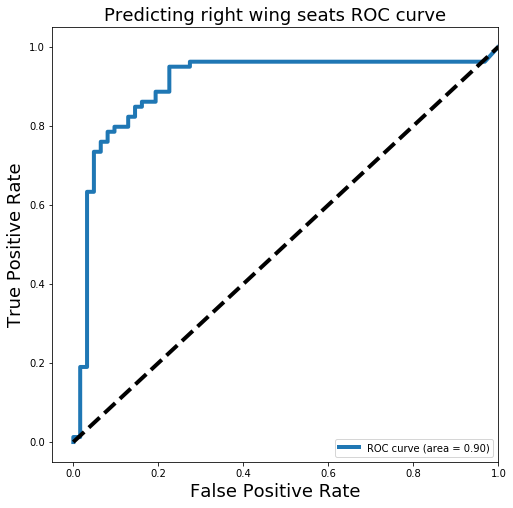

In [116]:
md.roc_curve_grapher(en_y_test,en_probs['is_right_pct'],title='Predicting right wing seats ROC curve')

* The AUC isn't too different to the previous models, and isn't up to scratch with 0.92 like in Model 3.

In [117]:
#Putting the coefficients and zipping them with the coefficient names
en_c_coefs = pd.DataFrame(dict(zip(en_X_train.columns,lr_en_mod.coef_[0])),index=['Value']).T
en_c_coefs['ABS_Value'] = en_c_coefs['Value'].apply(abs)
en_c_coefs['Probability'] = c_coefs['Value'].apply(md.logit_convert)
en_c_coefs.sort_values(by='Value',ascending=False)

,Value,ABS_Value,Probability
rental_hiring_and_real_estate_services_pct,1.575937,1.575937,0.794938
employer_government_includes_defence_housing_authority_pct,1.473236,1.473236,0.712561
hrswrkd_49_hours_and_over_pct,1.220655,1.220655,0.705511
western_europe_pct,1.162378,1.162378,0.727547
southern_and_east_africa_pct,1.097794,1.097794,0.641736
both_not_stated___both_institution_typp_and_full_time_part_time,1.057028,1.057028,0.745299
being_occupied_under_a_life_tenure_scheme_pct,1.043198,1.043198,0.711385
wholesale_trade_pct,0.999863,0.999863,0.663230
male_pct,0.916948,0.916948,0.668702
_65_69_years_pct,0.910301,0.910301,0.676781


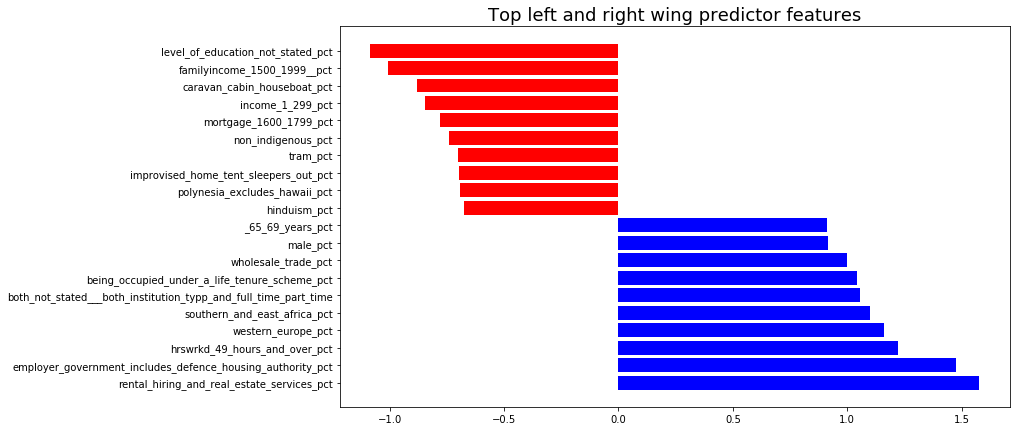

In [118]:
#Graphing the top left and right wing predictors (refer to docstring)
md.coef_grapher(en_c_coefs,title='Top left and right wing predictor features')

* While improving over the original, this model still doesn't stand up to model 3 in terms of predictive power over the 2019 election and coefficient insights. 


* After running 5 different models and outputting 5 different sets of left and right wing predictions I am starting to see a pattern in the differences. A recurring theme is the proportion of married persons and proportion of Christians for right leaning predictors. While for left leaning predictors it's usually associated with higher levels of education and greater public transport usage.